# Proyecto 1: Autoencoder

+ Erick Machuca Buenrostro
+ Año: 2024
+ Email: `erick.machuca@iteso.mx`

### El objetivo de este proyecto es crear un autoencoder convolucional utilizando el conjunto de datos de MedMNIST. El autoencoder tiene la tarea de reducir el ruido en las imágenes, es decir, tendrá que recibir como entrada las imágenes con ruido, y la salida debe ser las imágenes pero sin ruido. Para el autoencoder se utilizó la biblioteca de PyTorch, y el subcojunto de imágenes utilizado para entrenarlo fue el de TissueMNIST.

In [1]:
! pip install medmnist # Instalación de medmnist

  Obtaining dependency information for medmnist from https://files.pythonhosted.org/packages/8e/4b/83a368105698e77a7a972190973a5437a9a51789828562e1913687be9515/medmnist-3.0.1-py3-none-any.whl.metadata
  Using cached medmnist-3.0.1-py3-none-any.whl.metadata (13 kB)
  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/33/29/1d696450464d6e13358d3ef185a1fb14a11181c5dab1eb2837c02be86373/scikit_image-0.21.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached scikit_image-0.21.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached fire-0.5.0-py2.py3-none-any.whl
  Obtaining dependency information for imageio>=2.27 from https://files.pythonhosted.org/packages/02/25/66533a8390e3763cf8254dee143dbf8a830391ea60d2762512ba7f9ddfbe/imageio-2.34.0-py3-none-any.whl.metadata
  Using cached imageio-2.34.0-py3-none-any.whl.metadata (4.9 kB)
  Obtaining dependency information for tifffile>=2022.8.12

#### Parte I.

Instalación de medmnist e importación de librerias que usaremos para el modelo, visualización, gráficas, y funciones a utilizar.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from medmnist import TissueMNIST
#dataset = TissueMNIST(split="test", download=True)|

In [4]:
train_dataset = TissueMNIST(split="train", download=True)
test_dataset  = TissueMNIST(split="test", download=True)

Using downloaded and verified file: /home/studio-lab-user/.medmnist/tissuemnist.npz
Using downloaded and verified file: /home/studio-lab-user/.medmnist/tissuemnist.npz


In [5]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset TissueMNIST of size 28 (tissuemnist)
    Number of datapoints: 165466
    Root location: /home/studio-lab-user/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'Collecting Duct, Connecting Tubule', '1': 'Distal Convoluted Tubule', '2': 'Glomerular endothelial cells', '3': 'Interstitial endothelial cells', '4': 'Leukocytes', '5': 'Podocytes', '6': 'Proximal Tubule Segments', '7': 'Thick Ascending Limb'}
    Number of samples: {'train': 165466, 'val': 23640, 'test': 47280}
    Description: We use the BBBC051, available from the Broad Bioimage Benchmark Collection. The dataset contains 236,386 human kidney cortex cells, segmented from 3 reference tissue specimens and organized into 8 categories. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. Each gray-scale image is 32×32×7 pixels, where 7 denotes 7 slices. We take maximum values across the slices and resize them into 28×28 gray-scale

-----

Aquí podemos ver información del dataset utilizado. Podemos ver que el conjunto de pruebas contiene 165,466 muestras, en el caso del de pruebas, cuenta con 47,280 imágenes. Las imágenes son de células de la corteza del riñón humano y cuentan con 8 clases, que trata de diferentes nombres de células. En nuestro caso sólo utilizamos los datasets de entrenamiento/prueba. También muestra que cada imágen sólo tiene 1 canal, lo cual indica que es a escala de grises, y cada imágen es de shape 28x28. 

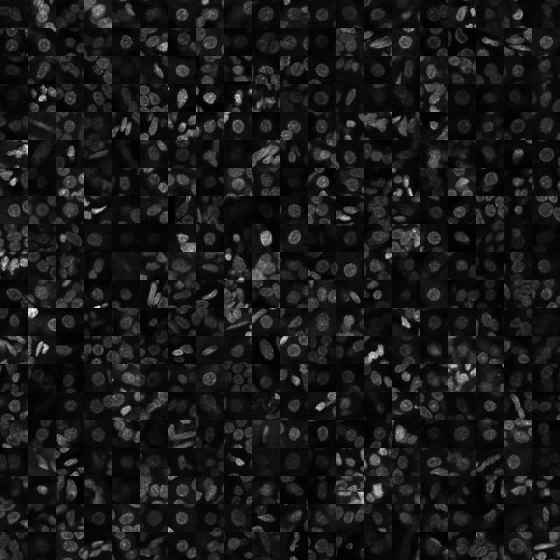

In [6]:
num_images = 20
train_dataset.montage(length=num_images) # Visualización de algunas imágenes

In [8]:
# Transformación a tensores
train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

batch_size=128
# Crear el data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

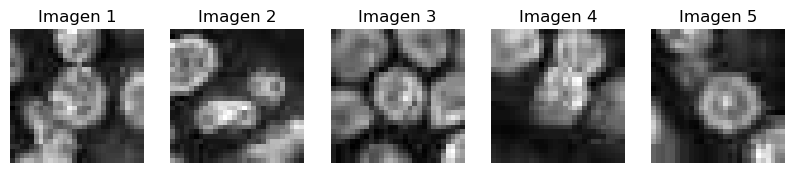

In [9]:
# Visualización de más cerca
def imshow_train(images, titles):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(10, 4))
    for i in range(num_images):
        axes[i].imshow(images[i][0], cmap='gray')
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.show()

num_images = 5
train_loader = DataLoader(train_dataset, batch_size=num_images, shuffle=True)
train_batch, _ = next(iter(train_loader))

# Muestra las imágenes originales de entrenamiento en escala de grises lado a lado
imshow_train(train_batch, ["Imagen "+str(i+1) for i in range(num_images)])

Para aplicar el ruido a las imágenes se creó una función, para el ae se estableció que el factor de ruido fuera 0.2.

In [10]:
def add_noise(image, noise_factor=0.2):
    noisy_image = image + noise_factor * torch.randn_like(image)
    return torch.clamp(noisy_image, 0., 1.)

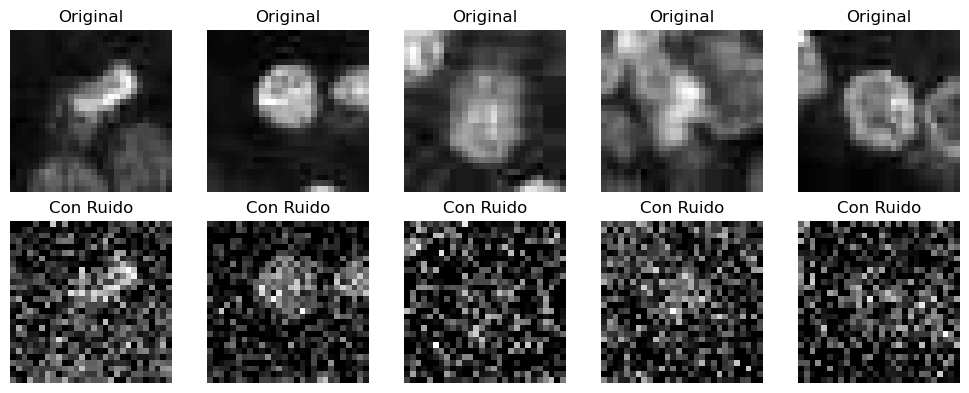

In [11]:
# Función para mostrar imágenes lado a lado
def imshow_comparison(original_images, noisy_images):
    num_images = len(original_images)
    fig, axes = plt.subplots(2, num_images, figsize=(10, 4))
    
    for i in range(num_images):
        axes[0, i].imshow(original_images[i][0], cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(noisy_images[i][0], cmap='gray')
        axes[1, i].set_title("Con Ruido")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Selecciona algunas imágenes de entrenamiento y aplica ruido
num_images = 5
train_loader = DataLoader(train_dataset, batch_size=num_images, shuffle=True)
original_batch, _ = next(iter(train_loader))
noisy_batch = add_noise(original_batch)

# Muestra las imágenes originales y con ruido lado a lado
imshow_comparison(original_batch, noisy_batch)

Luego de ver que la función aplica correctamente el ruido a las imágenes, procedemos a definir el modelo.

In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

El modelo a entrenar es uno convolucional, y la arquitectura del encoder es la siguiente:
+ Tiene inputs de (128,1,28,28), donde el 128 es el batch_size, 1 del canal de color, y el shape de la imágen en sí
+ Dos capas conv2d

El decoder:
+ Tiene dos capas ConvTranspose2d
+ El output será el mismo que el input

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for data in train_loader:
        images, _ = data
        noisy_images = add_noise(images)
        images = images.to(device)
        noisy_images = noisy_images.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.0021
Epoch [2/100], Loss: 0.0021
Epoch [3/100], Loss: 0.0021
Epoch [4/100], Loss: 0.0020
Epoch [5/100], Loss: 0.0020
Epoch [6/100], Loss: 0.0019
Epoch [7/100], Loss: 0.0019
Epoch [8/100], Loss: 0.0021
Epoch [9/100], Loss: 0.0020
Epoch [10/100], Loss: 0.0022
Epoch [11/100], Loss: 0.0019
Epoch [12/100], Loss: 0.0020
Epoch [13/100], Loss: 0.0019
Epoch [14/100], Loss: 0.0020
Epoch [15/100], Loss: 0.0019
Epoch [16/100], Loss: 0.0020
Epoch [17/100], Loss: 0.0019
Epoch [18/100], Loss: 0.0020
Epoch [19/100], Loss: 0.0019
Epoch [20/100], Loss: 0.0020
Epoch [21/100], Loss: 0.0019
Epoch [22/100], Loss: 0.0020
Epoch [23/100], Loss: 0.0020
Epoch [24/100], Loss: 0.0021
Epoch [25/100], Loss: 0.0019
Epoch [26/100], Loss: 0.0019
Epoch [27/100], Loss: 0.0018
Epoch [28/100], Loss: 0.0020
Epoch [29/100], Loss: 0.0020
Epoch [30/100], Loss: 0.0018
Epoch [31/100], Loss: 0.0019
Epoch [32/100], Loss: 0.0018
Epoch [33/100], Loss: 0.0019
Epoch [34/100], Loss: 0.0021
Epoch [35/100], Loss: 0

Ahora vamos a comparar las imágenes reconstruidas contra las originales

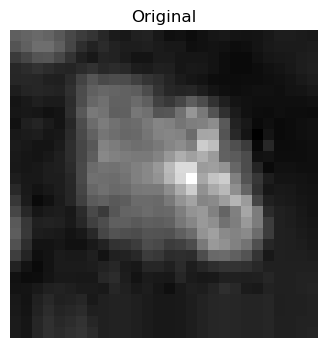

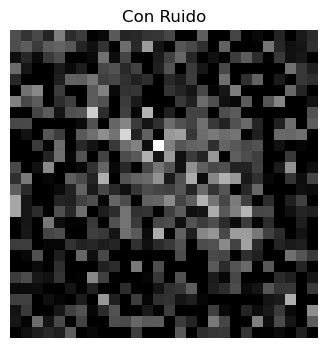

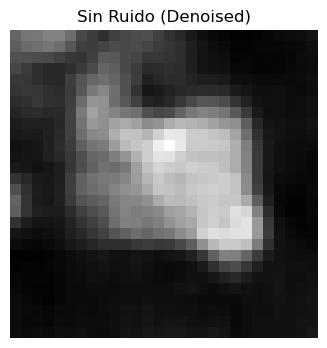

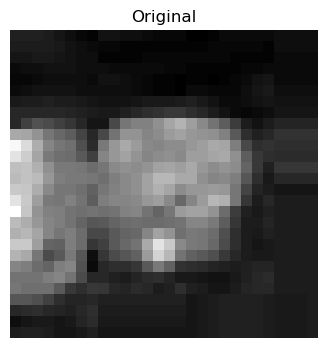

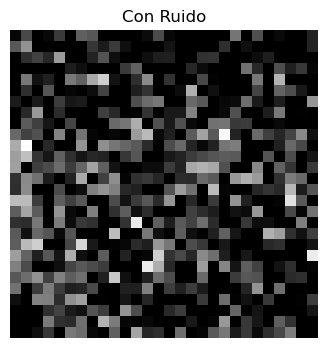

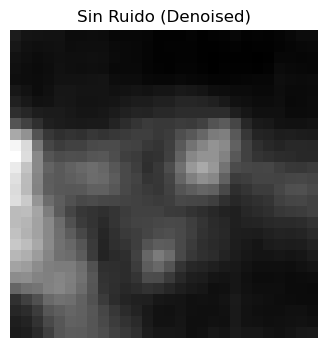

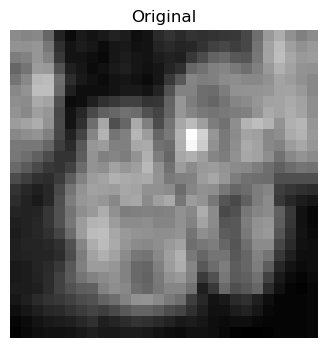

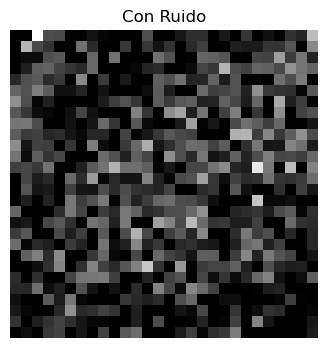

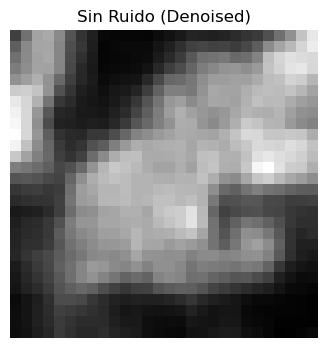

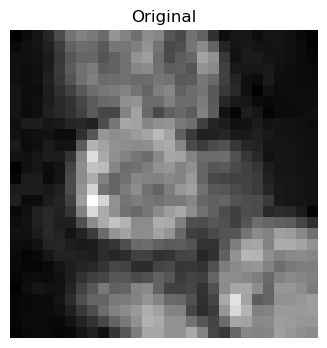

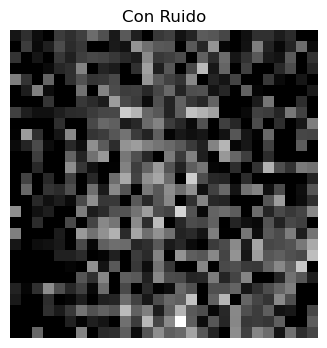

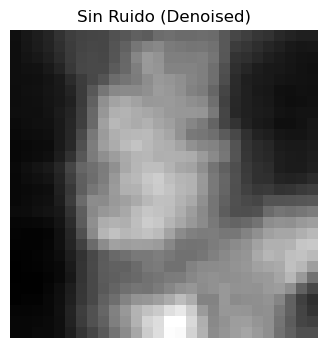

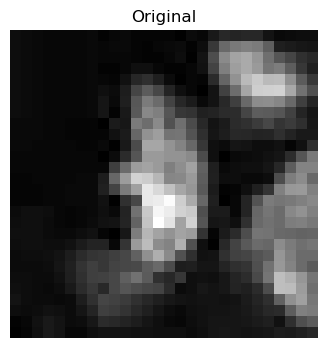

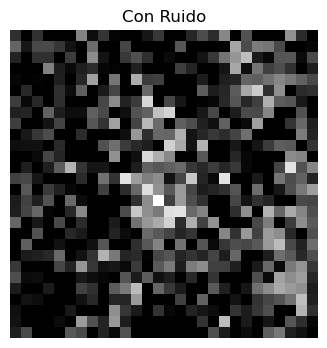

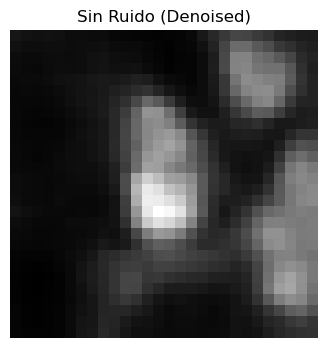

In [15]:
# Función para mostrar imágenes
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()
    
num_images = 5
test_batch, _ = next(iter(test_loader))
test_noisy_batch = add_noise(test_batch)

# Pasa las imágenes de prueba ruidosas por el autoencoder
model.eval()
with torch.no_grad():
    denoised_images = model(test_noisy_batch.to(device)).cpu()

# Muestra las imágenes originales, ruidosas y denoisedas
for i in range(num_images):
    imshow(test_batch[i], title="Original")
    imshow(test_noisy_batch[i], title="Con Ruido")
    imshow(denoised_images[i], title="Sin Ruido (Denoised)")


### Conclusiones
Al ver las imágenes originales contra las reconstruidas, podemos observar que el modelo logró tener un desempeño decente, aunque podría ser mejor. Hay algunas las cuales reconstruye mejor que las otras. El rendimiento podría mejorar con capas adicionales. Esto podría ser útil en los casos donde las imágenes tomadas de las células no fueron suficientemente buenas en cuanto a calidad. El modelo entonces nos ayudaría a tomar esas imágenes y las recrearía de manera que pueda ayudar a la aplicación médica.